In [2]:
!pip install --user python-chess==0.31.3


In [3]:
import chess
import chess.engine
import random
import numpy

#we will generate test dataset by creating random chess positions, and then using some external evaluator to get the evaluation number
def random_board(max_moves=200):
  board = chess.Board()
  depth = random.randrange(0,max_moves)
  for _ in range(depth):
    possible_moves = list(board.legal_moves)
    random_move = random.choice(possible_moves)
    board.push(random_move)
    if(board.is_game_over()):
      break
  return board


In [22]:
#set this path to the path where stockfish is installed in ur system
stockfish_path = r"C:\Users\adibh\stockfish\stockfish-windows-x86-64-avx2.exe"

# Initialize the engine
def stockfish(board,depth):
  with chess.engine.SimpleEngine.popen_uci(stockfish_path) as sf:
    result = sf.analyse(board, chess.engine.Limit(depth=depth))
    score = result['score'].white().score()
    return score

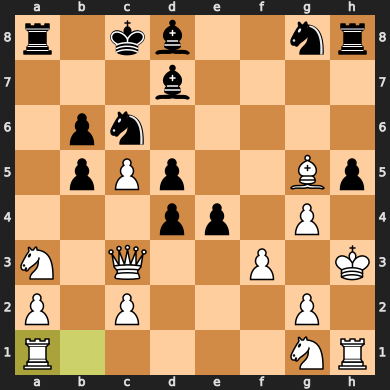

In [26]:
board = random_board()
board

In [31]:
#just testing it out, clearly white is better
print(board)
print(stockfish(board,10))

r . k b . . n r
. . . b . . . .
. p n . . . . .
. p P p . . B p
. . . p p . P .
N . Q . . P . K
P . P . . . P .
R . . . . . N R
-554


In [47]:
squares_index = {
    'a':0,'b':1,'c':2,'d':3,'e':4,'f':5,'g':6,'h':7
}
def square_to_index(square):
    letter = chess.square_name(square)
    return 8-int(letter[1]),squares_index[letter[0]]
def board_to_array(board):
    boardarr = numpy.zeros((14,8,8),dtype=numpy.int32)
#     boardarr[0] --> piece type
#     boardarr[1],[2] --> cell location
    for piece in chess.PIECE_TYPES: #this generates all types of pieces. each piece is denoted by some numerical value
        for square in board.pieces(piece,chess.WHITE):
            #this gives list of all squares where the needed piece is present
            idx = numpy.unravel_index(square,(8,8))
            boardarr[piece-1][7-idx[0]][idx[1]] = 1 #white piece info in the range boardarr[0] to boardarr[5]
        for square in board.pieces(piece,chess.BLACK):
            #this gives list of all squares where the needed piece is present
            idx = numpy.unravel_index(square,(8,8))
            boardarr[piece+5][7-idx[0]][idx[1]] = 1 #black piece info in the range boardarr[6] to boardarr[11]
    #we will add 2 extra dimensions , in each dimension we will mark 1 at some x,y if that position is attack by any piece of opponent
    cp = board.turn
    board.turn = chess.WHITE
    for move in board.legal_moves:
        i,j = square_to_index(move.to_square)
        boardarr[12][i][j] = 1
    board.turn = chess.BLACK
    for move in board.legal_moves:
        i,j = square_to_index(move.to_square)
        boardarr[13][i][j] = 1
    board.turn = cp
    return boardarr
        
            
        

In [119]:
type(board_to_array(board))


numpy.ndarray

In [8]:
import tensorflow

In [54]:
import tensorflow.keras.models as model
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
def build_model(conv_size,conv_depth):
    board3d = layers.Input(shape=(14,8,8))
    x = board3d
    for _ in range(conv_depth):
        x = layers.Conv2D(filters=conv_size,kernel_size = 3,padding='same',activation='relu',input_shape=(14,8,8))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64,'relu')(x)
    x = layers.Dense(1,'sigmoid')(x)
    return tensorflow.keras.models.Model(inputs=board3d,outputs =x)
    

In [10]:
chess_model = build_model(32,4)
chess_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d (Conv2D)             (None, 14, 8, 32)         2336      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 flatten (Flatten)           (None, 3584)              0         
                                                                 
 dense (Dense)               (None, 64)                229440

In [45]:

!pip install pydot

In [47]:
!pip install graphviz

     -------------------------------------- 47.1/47.1 kB 801.9 kB/s eta 0:00:00


In [11]:
import tensorflow.keras.models as model
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
def build_model_residual(conv_size, conv_depth):
    board3d = layers.Input(shape=(14,8,8))
    x = layers.Conv2D(filters=conv_size,kernel_size=3,padding='same')(board3d)
    for _ in range(conv_depth):
        previous = x
        
        x = layers.Conv2D(filters=conv_size,kernel_size = 3,padding='same',activation='relu',input_shape=(14,8,8))(x)
        x=layers.BatchNormalization()(x)
        x=layers.Activation('relu')(x)
        x = layers.Conv2D(filters=conv_size,kernel_size = 3,padding='same',activation='relu',input_shape=(14,8,8))(x)
        x=layers.BatchNormalization()(x)
        x=layers.Activation('relu')(x)
        x=layers.Add()([x,previous])
        x=layers.Activation('relu')(x)       
        
    x = layers.Flatten()(x)
    x = layers.Dense(1,'sigmoid')(x)
    return model.Model(inputs=board3d,outputs =x)

In [12]:
res_model = build_model_residual(32,4)
res_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 14, 8, 8)]   0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 14, 8, 32)    2336        ['input_2[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 14, 8, 32)    9248        ['conv2d_4[0][0]']               
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 8, 32)   128         ['conv2d_5[0][0]']               
 alization)                                                                                 

In [58]:
#let us now generate 100k random boards and store it in x_train,y_train
import time

# Record the start time
start_time = time.time()

# Code to be measured





no_samples = 10
x_elements = []
y_elements = []
for _ in range(no_samples):
    board = random_board()
    y_tag = stockfish(board,4)
    x_tag = board_to_array(board)
    x_elements.append(x_tag)
    y_elements.append(y_tag)
result_x = numpy.concatenate(x_elements, axis=0).reshape(no_samples, 14,8,8)
result_y = numpy.array(y_elements)
result_y = result_y/abs(result_y.max())/2+0.5
print(result_x.shape," ",result_y.shape)
# Record the end time
end_time = time.time()

# Calculate the duration
duration = end_time - start_time
print(duration)

(10, 14, 8, 8)   (10,)
2.9315831661224365


In [59]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, CSVLogger
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('model.h5', save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
csv_logger = CSVLogger('training.log')
chess_model.compile(optimizer = optimizers.Adam(5e-4),loss='mean_squared_error')
chess_model.summary()
chess_model.fit(result_x,result_y,batch_size=1,epochs=100,verbose=1,validation_split=0.1)
chess_model.save('model.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d (Conv2D)             (None, 14, 8, 32)         2336      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 8, 32)         9248      
                                                                 
 flatten (Flatten)           (None, 3584)              0         
                                                                 
 dense (Dense)               (None, 64)                229440